In [1]:
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


In [2]:
# 텐서플로 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


### 모델 학습을 위한 데이터셋(dataset) 준비하기
---
- `tensorflow_datasets`는 텐서플로우가 제공하는 데이터셋 모음집
- 음성 데이터셋, 이미지 데이터셋, 텍스트 데이터셋 등 방대한 종류의 데이터셋을 제공
- https://www.tensorflow.org/datasets/catalog/overview

In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'4.4.0'

In [4]:
!mkdir -p ~/aiffel/cats_vs_dogs/PetImages
!ln -s ~/data/* ~/aiffel/cats_vs_dogs/

ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/cat_face.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/cats_vs_dogs': File exists
ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/my_cat.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/cats_vs_dogs/my_dog.jpg': File exists


In [5]:
# 데이터 불러와 학습/검증/테스트 세트로 분할하기
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/cats_vs_dogs/',
    download=False,
    with_info=True,
    as_supervised=True,
)

In [6]:
# 데이터 형태 출력하기
# tfds의 raw 데이터는 ((이미지 데이터 shape), (label 데이터 shape)) 형태로 출력된다
# 이미지 데이터셋 내 이미지 크기가 전부 다르기 때문에 width, heith가 None으로 출력된다

print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### 데이터 시각화를 통해 확인하고, 모델에 입력할 수 있는 형태로 전처리하기
---

- `take()` :tf.data.Dataset에서 제공하는 함수. 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수이다

In [7]:
# 라이브러리 가져오기
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

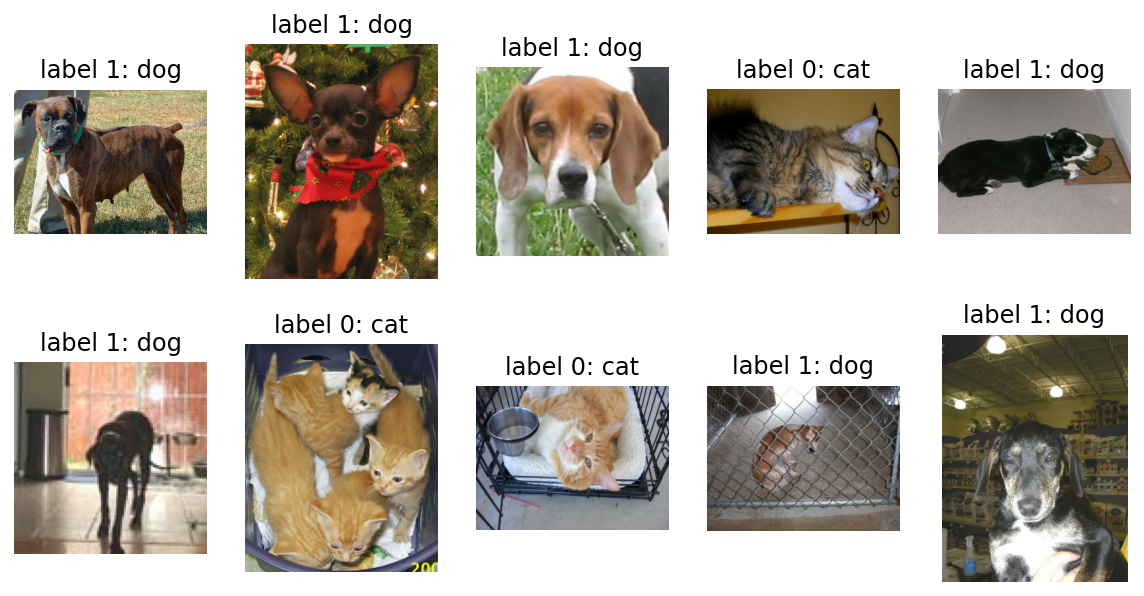

In [8]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)): # 10개 데이터 가져오기
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 이미지를 같은 포맷으로 통일시키기
---
- format_example(): 이미지의 사이즈를 160x160 픽셀로 통일시킬 뿐만 아니라, 각 픽셀값의 scale을 수정해주는 역할
- `타입캐스팅(Type Casting)` : 
형변환이라고도 불리는 타입개스팅은 다른 데이터 타입으로 형(타입)을 바꿔주는 것을 의미합니다.



In [9]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [10]:
# raw 데이터를 변환해준다
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


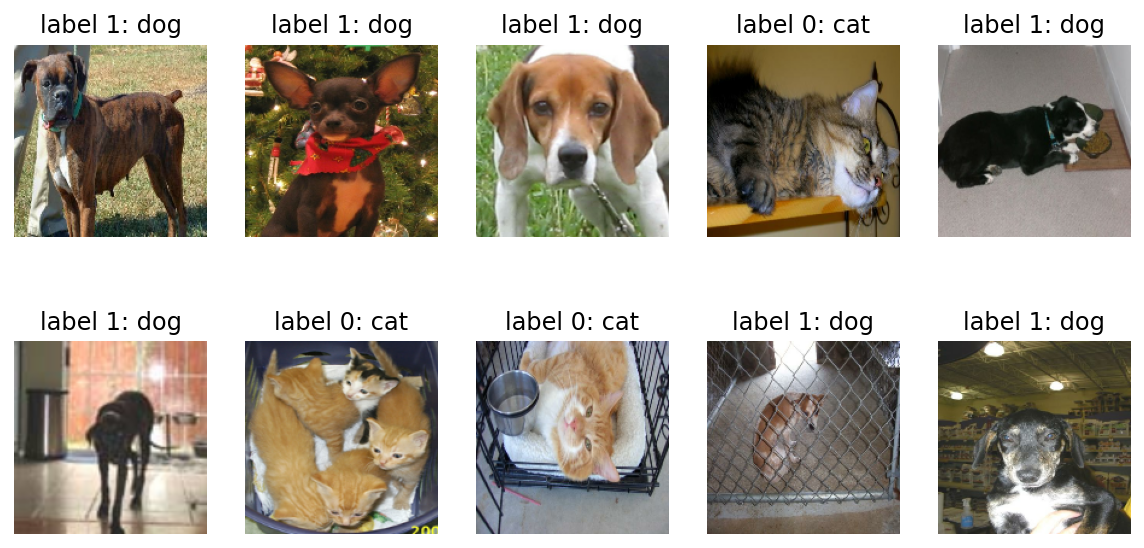

In [11]:
# matplotlib으로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야 하므로, -1~1 사이의 픽셀값을 1을 더한 후 2로 나눠서 0~1 사이의 값으로 변환한다
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 모델 만들기
---

### 텐서플로우를 활용해 모델 구조 설계하기

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [13]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [14]:
# 모델 전체구조 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

### 모델 compile 완료 후 학습시키기
---
- optimizer는 학습을 어떤 방식으로 시킬 것인지 결정합니다. 어떻게 최적화시킬 것인지를 결정하기 때문에 최적화 함수라고 부르기도 합니다.  
- loss는 모델이 학습해나가야 하는 방향 을 결정합니다. 이 문제에서는 모델의 출력은 입력받은 이미지가 고양이인지 강아지인지에 대한 확률분포로 두었으므로, 입력 이미지가 고양이(label=0)일 경우 모델의 출력이 [1.0, 0.0]에 가깝도록, 강아지(label=1)일 경우 [0.0, 1.0]에 가까워지도록 하는 방향을 제시합니다.  
- metrics는 모델의 성능을 평가하는 척도 입니다. 분류 문제를 풀 때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있습니다. 여기서는 정확도를 사용했습니다.

In [15]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [17]:
# BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 만든다
# train_batches는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 준다

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [18]:
# train_batches에서 하나의 batch만 꺼내 데이터 확인해보자
for image_batch, label_batch in train_batches.take(1):
    break
    
image_batch.shape, label_batch.shape # batch 크기 만큼의 resize된 이미지와 label을 확인할 수 있다.

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [19]:
# 초기 모델의 성능을 확인해보자
# validation(검증)을 하기 위한 데이터셋인 validation_batches를 이용해 20번의 예측을 해 보고, 평균 loss와 평균 accuracy를 확인해 본다

validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# initial loss: 0.69
# initial accuracy: 0.52

11/20 [===============>..............] - ETA: 0s - loss: 0.6885 - accuracy: 0.5369

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 3s 30ms/step - loss: 0.6889 - accuracy: 0.5469
initial loss: 0.69
initial accuracy: 0.55


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


In [20]:
# 학습
EPOCHS = 10
history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

# loss: 0.0852 - accuracy: 0.9728 - val_loss: 0.6530 - val_accuracy: 0.7915


Epoch 1/10
170/582 [=======>......................] - ETA: 18s - loss: 0.6592 - accuracy: 0.6127

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 16s - loss: 0.6521 - accuracy: 0.6190

212/582 [=========>....................] - ETA: 16s - loss: 0.6498 - accuracy: 0.6204

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 12s - loss: 0.6372 - accuracy: 0.6333

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.6018 - accuracy: 0.6675

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.6006 - accuracy: 0.6692

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.6001 - accuracy: 0.6700

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.5957 - accuracy: 0.6741

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.5945 - accuracy: 0.6750

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.6781

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 29s 46ms/step - loss: 0.5904 - accuracy: 0.6781 - val_loss: 0.6099 - val_accuracy: 0.6801
Epoch 2/10
170/582 [=======>......................] - ETA: 17s - loss: 0.5088 - accuracy: 0.7489

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 15s - loss: 0.5062 - accuracy: 0.7508

212/582 [=========>....................] - ETA: 15s - loss: 0.5051 - accuracy: 0.7512

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 12s - loss: 0.4986 - accuracy: 0.7557

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.4777 - accuracy: 0.7685

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.4784 - accuracy: 0.7684

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.4774 - accuracy: 0.7691

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.4750 - accuracy: 0.7711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.4746 - accuracy: 0.7713

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.7714

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 27s 45ms/step - loss: 0.4737 - accuracy: 0.7715 - val_loss: 0.4900 - val_accuracy: 0.7670
Epoch 3/10
170/582 [=======>......................] - ETA: 18s - loss: 0.4315 - accuracy: 0.8050

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 16s - loss: 0.4273 - accuracy: 0.8058

212/582 [=========>....................] - ETA: 16s - loss: 0.4262 - accuracy: 0.8066

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 12s - loss: 0.4220 - accuracy: 0.8091

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.4102 - accuracy: 0.8131

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.4102 - accuracy: 0.8131

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.4090 - accuracy: 0.8135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 1s - loss: 0.4076 - accuracy: 0.8147

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


550/582 [===========================>..] - ETA: 1s - loss: 0.4076 - accuracy: 0.8143

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8150

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 28s 46ms/step - loss: 0.4065 - accuracy: 0.8149 - val_loss: 0.4898 - val_accuracy: 0.7653
Epoch 4/10
171/582 [=======>......................] - ETA: 17s - loss: 0.3768 - accuracy: 0.8381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 [=========>....................] - ETA: 16s - loss: 0.3754 - accuracy: 0.8387

213/582 [=========>....................] - ETA: 15s - loss: 0.3762 - accuracy: 0.8385

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 12s - loss: 0.3689 - accuracy: 0.8406

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.3558 - accuracy: 0.8434

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.3553 - accuracy: 0.8438

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.3551 - accuracy: 0.8439

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 1s - loss: 0.3524 - accuracy: 0.8453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 1s - loss: 0.3516 - accuracy: 0.8458

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8462

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 28s 45ms/step - loss: 0.3499 - accuracy: 0.8462 - val_loss: 0.4818 - val_accuracy: 0.7777
Epoch 5/10
169/582 [=======>......................] - ETA: 18s - loss: 0.3220 - accuracy: 0.8645

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 [=========>....................] - ETA: 16s - loss: 0.3200 - accuracy: 0.8647

213/582 [=========>....................] - ETA: 15s - loss: 0.3173 - accuracy: 0.8668

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 12s - loss: 0.3133 - accuracy: 0.8702

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.3027 - accuracy: 0.8742

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.3029 - accuracy: 0.8743

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.3021 - accuracy: 0.8749

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.2989 - accuracy: 0.8764

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.2989 - accuracy: 0.8765

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8765

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 27s 45ms/step - loss: 0.2981 - accuracy: 0.8765 - val_loss: 0.4959 - val_accuracy: 0.7743
Epoch 6/10
170/582 [=======>......................] - ETA: 17s - loss: 0.2680 - accuracy: 0.8921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 16s - loss: 0.2673 - accuracy: 0.8923

212/582 [=========>....................] - ETA: 15s - loss: 0.2654 - accuracy: 0.8934

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 12s - loss: 0.2608 - accuracy: 0.8963

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.2498 - accuracy: 0.9003

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.2499 - accuracy: 0.9001

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.2498 - accuracy: 0.8999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 1s - loss: 0.2475 - accuracy: 0.9008

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 1s - loss: 0.2479 - accuracy: 0.9005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.9008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 27s 45ms/step - loss: 0.2457 - accuracy: 0.9009 - val_loss: 0.5120 - val_accuracy: 0.7893
Epoch 7/10
169/582 [=======>......................] - ETA: 17s - loss: 0.2206 - accuracy: 0.9114

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 16s - loss: 0.2187 - accuracy: 0.9128

213/582 [=========>....................] - ETA: 15s - loss: 0.2179 - accuracy: 0.9134

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 12s - loss: 0.2101 - accuracy: 0.9175

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.2006 - accuracy: 0.9224

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.1994 - accuracy: 0.9231

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.1992 - accuracy: 0.9232

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.1984 - accuracy: 0.9236

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.1978 - accuracy: 0.9238

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.1970 - accuracy: 0.9241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 28s 45ms/step - loss: 0.1969 - accuracy: 0.9241 - val_loss: 0.5402 - val_accuracy: 0.7846
Epoch 8/10
169/582 [=======>......................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9403

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 16s - loss: 0.1640 - accuracy: 0.9426

212/582 [=========>....................] - ETA: 15s - loss: 0.1628 - accuracy: 0.9430

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 12s - loss: 0.1603 - accuracy: 0.9433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.1532 - accuracy: 0.9434

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.1522 - accuracy: 0.9439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.1517 - accuracy: 0.9442

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.1511 - accuracy: 0.9442

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


548/582 [===========================>..] - ETA: 1s - loss: 0.1506 - accuracy: 0.9444

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.1488 - accuracy: 0.9451

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 27s 45ms/step - loss: 0.1487 - accuracy: 0.9451 - val_loss: 0.6206 - val_accuracy: 0.7730
Epoch 9/10
169/582 [=======>......................] - ETA: 19s - loss: 0.1287 - accuracy: 0.9527

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 17s - loss: 0.1253 - accuracy: 0.9554

213/582 [=========>....................] - ETA: 17s - loss: 0.1245 - accuracy: 0.9560

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 13s - loss: 0.1200 - accuracy: 0.9590

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.1137 - accuracy: 0.9615

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.1130 - accuracy: 0.9616

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.1134 - accuracy: 0.9613

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 1s - loss: 0.1117 - accuracy: 0.9619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


550/582 [===========================>..] - ETA: 1s - loss: 0.1113 - accuracy: 0.9620

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.1109 - accuracy: 0.9621

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 28s 47ms/step - loss: 0.1108 - accuracy: 0.9622 - val_loss: 0.6474 - val_accuracy: 0.7812
Epoch 10/10
169/582 [=======>......................] - ETA: 17s - loss: 0.0918 - accuracy: 0.9708

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/582 [=========>....................] - ETA: 16s - loss: 0.0908 - accuracy: 0.9708

211/582 [=========>....................] - ETA: 16s - loss: 0.0902 - accuracy: 0.9711

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 12s - loss: 0.0859 - accuracy: 0.9733

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.0817 - accuracy: 0.9744

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.0809 - accuracy: 0.9749

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


515/582 [=========================>....] - ETA: 2s - loss: 0.0809 - accuracy: 0.9748

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.0807 - accuracy: 0.9747

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.0805 - accuracy: 0.9748

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9750

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 28s 45ms/step - loss: 0.0801 - accuracy: 0.9750 - val_loss: 0.6974 - val_accuracy: 0.7928


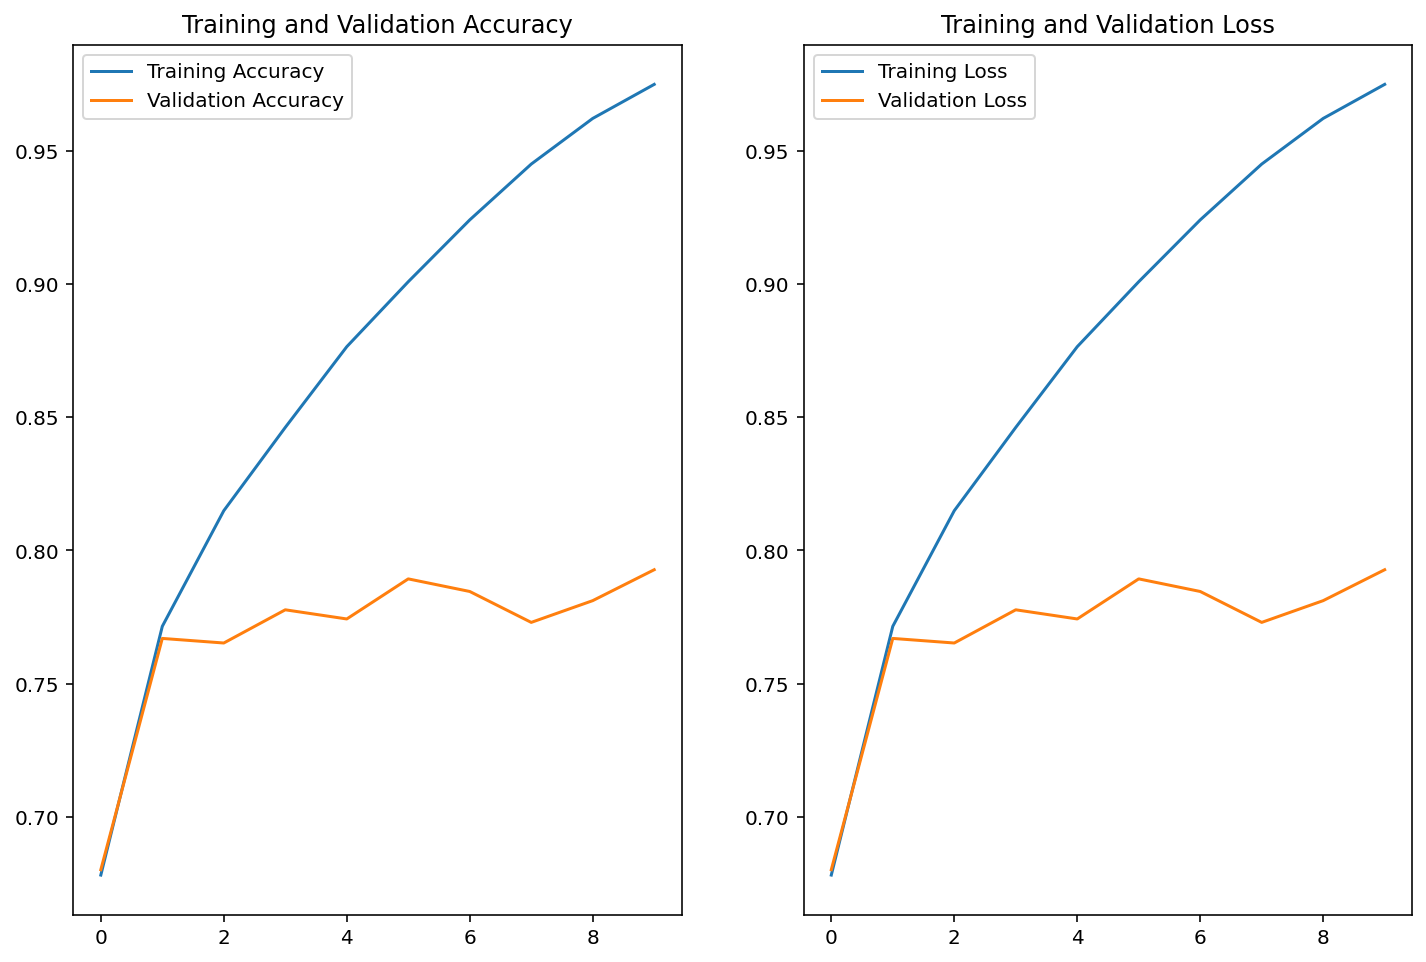

In [21]:
# 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1) # 1행의 2개의 서브플롯 중 1번째 서브플롯에 그린다
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # 1행의 2개의 서브플롯 중 2번째 서브플롯에 그린다
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [22]:
# 예측
# # test용 데이터에서 1개 배치만큼 꺼낸 후, 배치 안의 개별 데이터에 대해 예측 반복 수행
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break
    
predictions # [고양이 확률, 강아지 확률] 로 출력된다. 각 값이 1.0에 가까울수록 해당 클래스에 속할 확률이 높다

array([[9.9999595e-01, 4.0955269e-06],
       [8.3389759e-01, 1.6610236e-01],
       [5.4388356e-01, 4.5611647e-01],
       [9.9999309e-01, 6.8919603e-06],
       [9.0934694e-01, 9.0653107e-02],
       [7.1125597e-02, 9.2887437e-01],
       [2.8959677e-01, 7.1040326e-01],
       [5.8969986e-01, 4.1030014e-01],
       [4.5932222e-02, 9.5406783e-01],
       [7.7182388e-01, 2.2817612e-01],
       [1.4288932e-01, 8.5711068e-01],
       [9.9596548e-01, 4.0345429e-03],
       [9.9872702e-01, 1.2729288e-03],
       [7.3889350e-03, 9.9261111e-01],
       [9.9519217e-01, 4.8078680e-03],
       [9.2233104e-01, 7.7668950e-02],
       [9.7619402e-01, 2.3805989e-02],
       [2.0867416e-05, 9.9997914e-01],
       [6.6806287e-01, 3.3193713e-01],
       [9.9937290e-01, 6.2706938e-04],
       [9.9579155e-01, 4.2084479e-03],
       [9.7280914e-01, 2.7190855e-02],
       [9.9994969e-01, 5.0323702e-05],
       [9.9374145e-01, 6.2585818e-03],
       [9.9987030e-01, 1.2969055e-04],
       [2.9470436e-03, 9.

In [23]:
predictions.ndim

2

In [24]:
import numpy as np
predictions = np.argmax(predictions, axis=1) # 2차원 배열에 대해 각 행에 대하여 최대값인 인덱스 반환
predictions

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

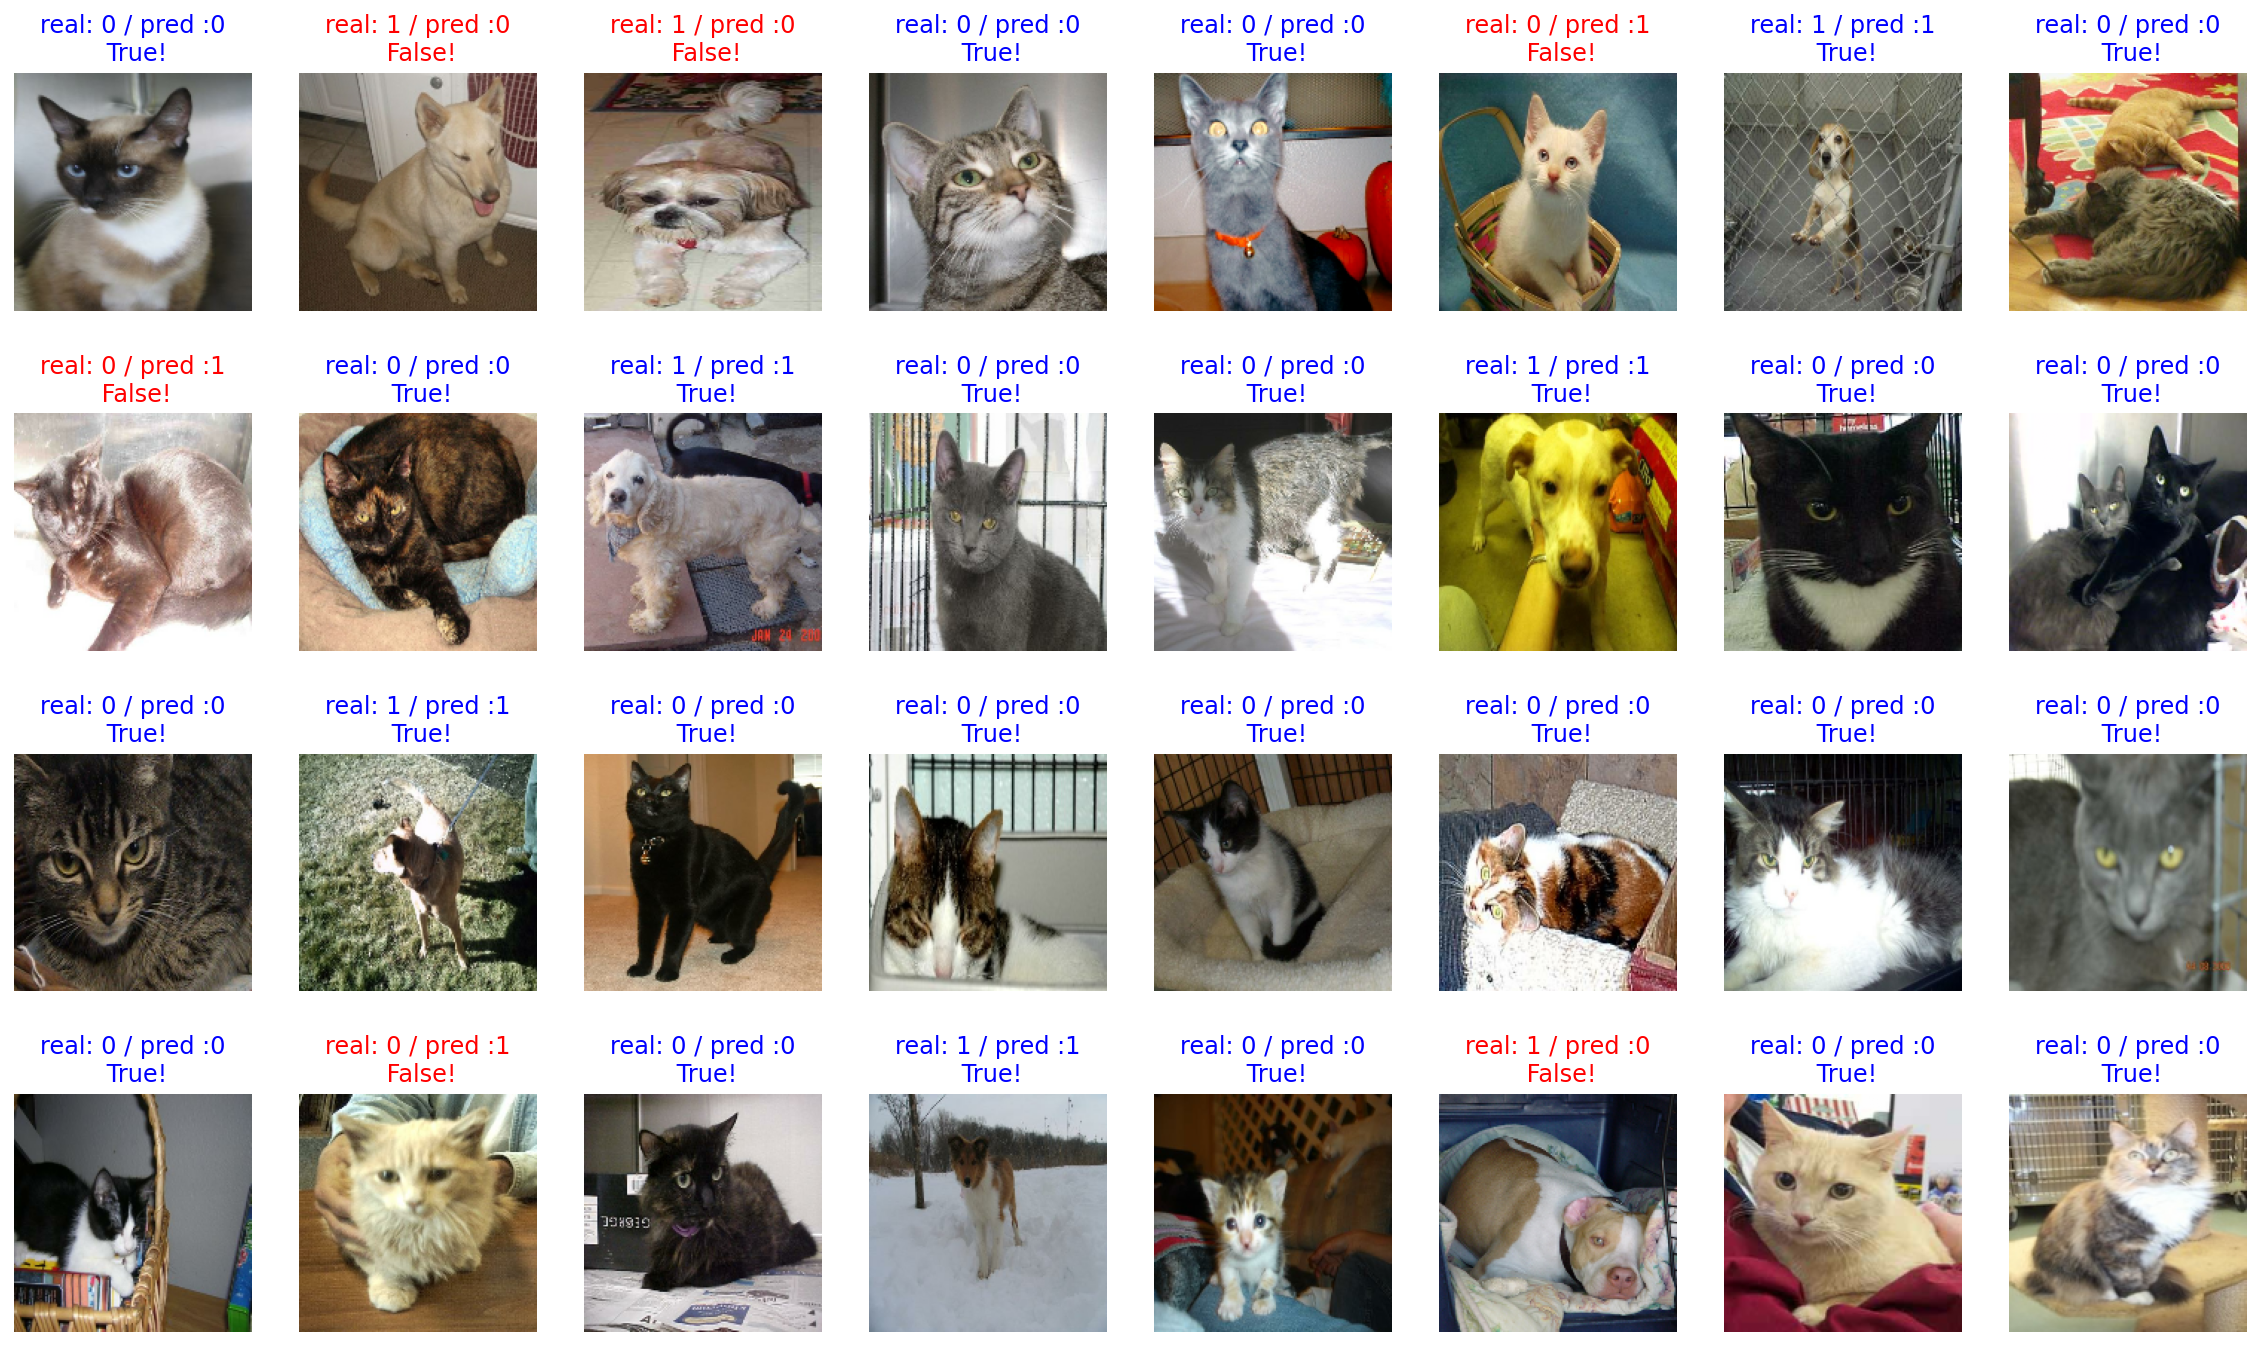

In [25]:
# 시각화하여 예측 결과를 확인해보자
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction # 예측값이 맞았는지 판단
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [26]:
# 32개 이미지에 대한 정확도 계산
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    # [[YOUR CODE]]
    if label == prediction :
        count += 1


print(count / 32 * 100)

81.25


### 사전 학습 모델인 VGG16을 가져오고, 모델의 구조 확인하기

In [27]:
IMG_SHAPE =(IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

In [28]:
# 학습시 사용했던 image_batch의 원래사이즈 확인
image_batch.shape

TensorShape([32, 160, 160, 3])

In [29]:
# 모델에 위 배치를 넣어보자
feature_batch = base_model(image_batch)
feature_batch.shape # output featuremap 사이즈. 특징벡터라고도 부른다

TensorShape([32, 5, 5, 512])

In [30]:
# 모델의 구조 확인
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [32]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average) # GAP 결과
print(feature_batch_average.shape) # featuremap GAP 후 형태

tf.Tensor(
[[1.6986297e-01 0.0000000e+00 5.3184342e-02 ... 4.3856405e-02
  2.9701477e-01 1.4242614e-03]
 [1.6501422e-01 0.0000000e+00 2.8996757e-01 ... 3.3939775e-02
  5.4036582e-01 6.4178946e-04]
 [5.2900171e-01 0.0000000e+00 6.5627235e-01 ... 3.0048695e-01
  5.1570219e-01 0.0000000e+00]
 ...
 [7.8398317e-01 0.0000000e+00 6.2625200e-01 ... 2.1022132e-02
  2.9255277e-01 2.3261989e-03]
 [2.0012325e-01 0.0000000e+00 1.2895697e-01 ... 1.7264047e-01
  6.2728029e-01 6.6618621e-02]
 [2.8448799e-01 0.0000000e+00 7.1031404e-01 ... 3.4998983e-02
  3.1748247e-01 4.8274131e-04]], shape=(32, 512), dtype=float32)
(32, 512)


In [33]:
# classifier
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer = tf.keras.layers.Dense(512, activation='relu')

# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 2)


In [34]:
base_model.trainable = False

In [35]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


# VGG16을 기반으로 구성된 이미지 분류기를 학습시키고, 직접 만들었던 모델과 결과 비교해 보기
---

In [37]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [38]:
# 평가
validation_step=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# initial loss: 1.07
# initial accuracy: 0.53

 6/20 [========>.....................] - ETA: 0s - loss: 0.6861 - accuracy: 0.5156

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


18/20 [==========================>...] - ETA: 0s - loss: 0.6850 - accuracy: 0.5069

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 5s 67ms/step - loss: 0.6843 - accuracy: 0.5063
initial loss: 0.68
initial accuracy: 0.51


In [39]:
EPOCHS = 5

history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/5
167/582 [=======>......................] - ETA: 35s - loss: 0.3836 - accuracy: 0.8673

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 32s - loss: 0.3610 - accuracy: 0.8753

210/582 [=========>....................] - ETA: 31s - loss: 0.3552 - accuracy: 0.8772

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 25s - loss: 0.3219 - accuracy: 0.8881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.2687 - accuracy: 0.9018

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.2661 - accuracy: 0.9026

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.2641 - accuracy: 0.9032

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.2600 - accuracy: 0.9042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.2592 - accuracy: 0.9043

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2539 - accuracy: 0.9059

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 100ms/step - loss: 0.2539 - accuracy: 0.9059 - val_loss: 0.1759 - val_accuracy: 0.9269
Epoch 2/5
167/582 [=======>......................] - ETA: 34s - loss: 0.1639 - accuracy: 0.9356

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1629 - accuracy: 0.9358

210/582 [=========>....................] - ETA: 31s - loss: 0.1635 - accuracy: 0.9345

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 25s - loss: 0.1639 - accuracy: 0.9353

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1618 - accuracy: 0.9346

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1613 - accuracy: 0.9347

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9350

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1600 - accuracy: 0.9354

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1601 - accuracy: 0.9355

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9361

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.1593 - accuracy: 0.9361 - val_loss: 0.1535 - val_accuracy: 0.9381
Epoch 3/5
167/582 [=======>......................] - ETA: 34s - loss: 0.1458 - accuracy: 0.9401

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1485 - accuracy: 0.9388

210/582 [=========>....................] - ETA: 30s - loss: 0.1479 - accuracy: 0.9397

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1478 - accuracy: 0.9384

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1483 - accuracy: 0.9392

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1472 - accuracy: 0.9399

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1466 - accuracy: 0.9399

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1462 - accuracy: 0.9405

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1464 - accuracy: 0.9404

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9406

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.1458 - accuracy: 0.9406 - val_loss: 0.1447 - val_accuracy: 0.9390
Epoch 4/5
167/582 [=======>......................] - ETA: 34s - loss: 0.1355 - accuracy: 0.9427

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1374 - accuracy: 0.9423

210/582 [=========>....................] - ETA: 31s - loss: 0.1372 - accuracy: 0.9429

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 25s - loss: 0.1395 - accuracy: 0.9413

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1402 - accuracy: 0.9419

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1397 - accuracy: 0.9422

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1396 - accuracy: 0.9421

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1383 - accuracy: 0.9428

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1384 - accuracy: 0.9429

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9430

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.1384 - accuracy: 0.9430 - val_loss: 0.1403 - val_accuracy: 0.9424
Epoch 5/5
167/582 [=======>......................] - ETA: 34s - loss: 0.1321 - accuracy: 0.9482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1309 - accuracy: 0.9491

210/582 [=========>....................] - ETA: 30s - loss: 0.1311 - accuracy: 0.9490

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1345 - accuracy: 0.9463

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1356 - accuracy: 0.9450

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1356 - accuracy: 0.9451

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1352 - accuracy: 0.9451

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1344 - accuracy: 0.9454

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1342 - accuracy: 0.9456

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9458

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 91ms/step - loss: 0.1333 - accuracy: 0.9458 - val_loss: 0.1441 - val_accuracy: 0.9415


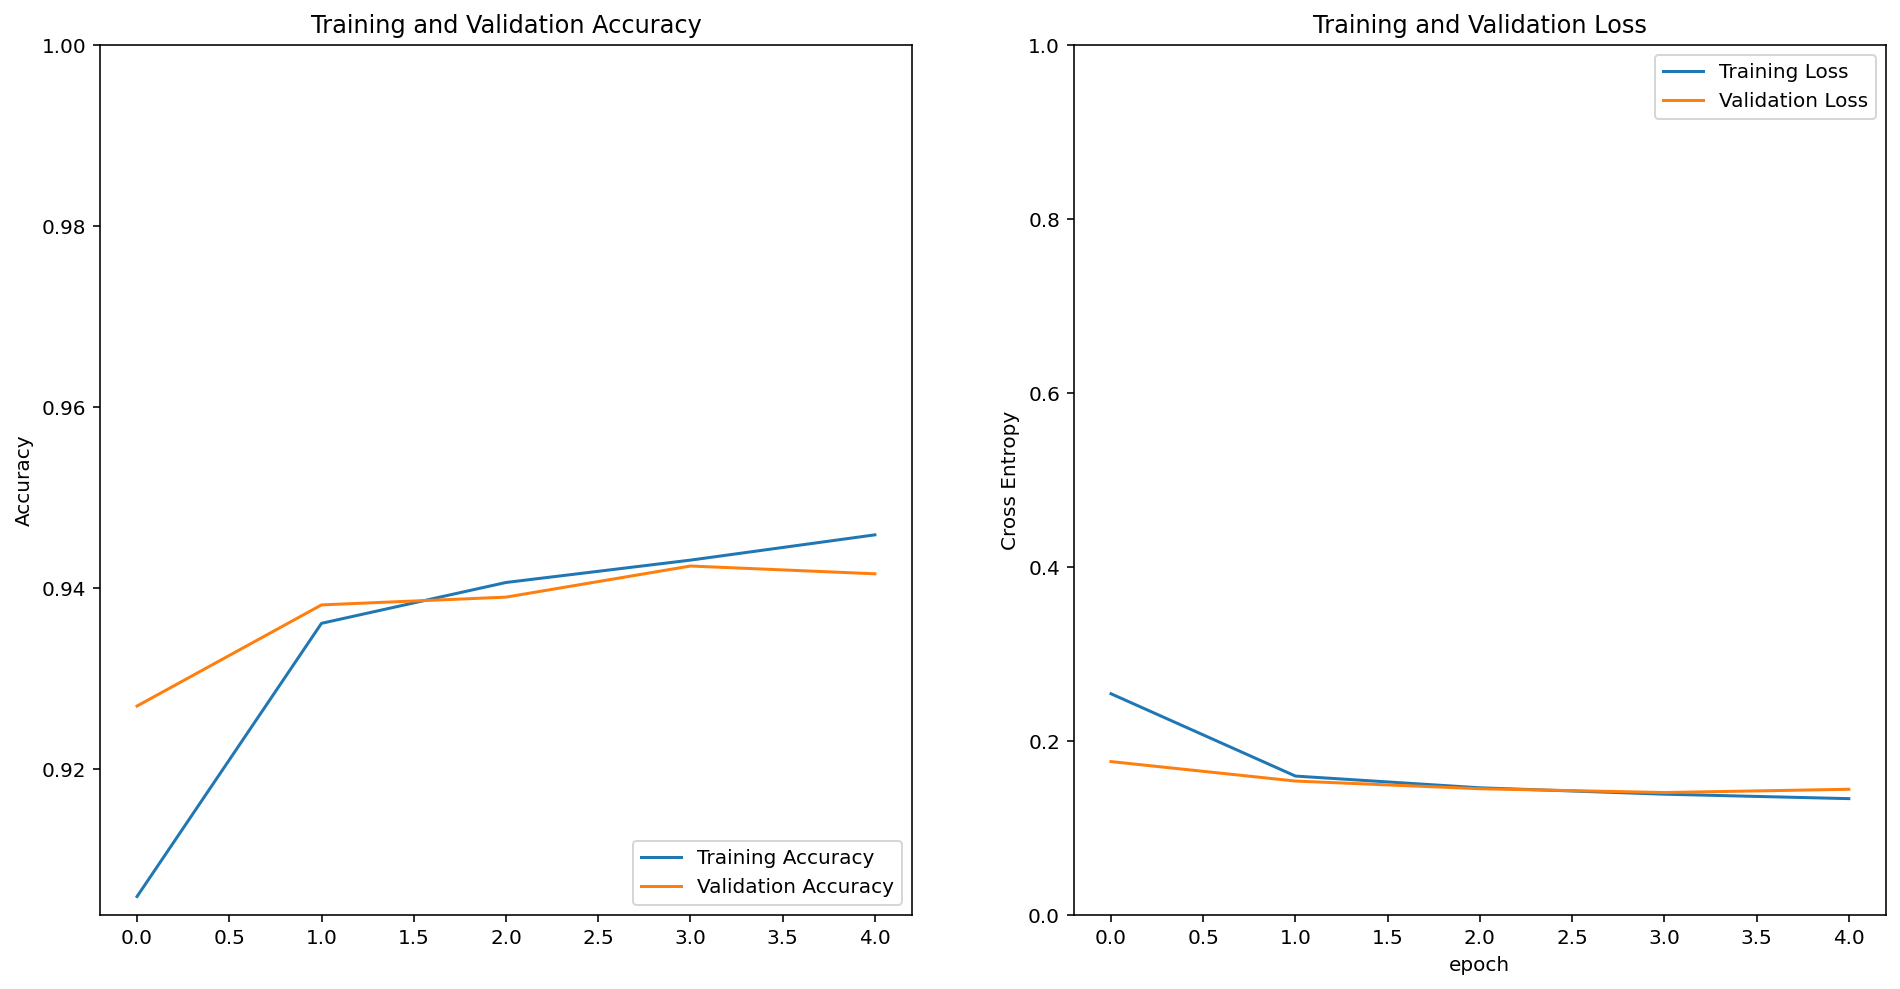

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
# 32개 test sample에 대해서 예측
for image_batch, label_batch in test_batch.take(1):
    images = image_batchbatch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

NameError: name 'test_batch' is not defined

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

In [ ]:
# 맞았는지 여부 시각화 (맞으면 파란색, 틀리면 빨간색으로 제목 표시)
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
# 32개에 대한 정확도 확인
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

### 모델을 save 하고, 다시 load 해와서 사용하는 방법 익히기

In [ ]:
!mkdir -p ~/aiffel/cat_vs_dog/checkpoint
!mkdir -p ~/aiffel/cat_vs_dog/images

In [ ]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/cat_vs_dog/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

In [ ]:
!ln -s ~/data/* ~/aiffel/cat_vs_dog/images/

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
IMG_SIZE = 160
img_dir_path = os.getenv("HOME") + "/aiffel/cat_vs_dog/images"
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

In [ ]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3) # 이미지 1장이니 batch 크기도 1
dog_image.shape

In [ ]:
prediction = model.predict(dog_image)
prediction

In [ ]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

In [ ]:
filename = 'my_dog.jpg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'my_cat.jpg'

show_and_predict_image(img_dir_path, filename)